<a href="https://colab.research.google.com/github/pmarote/tcc/blob/main/tcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?id=1wHOKRTSG0TF2HJzGI7iKcSdqVgja8dEf"  width="192px" align="right">
<p style="text-align: center; font-size: 200%; font-weight: bold; margin-top: 10px;"><b>UNIVERSIDADE DE SÃO PAULO</b></a></p>
<p style="text-align: center; font-size: 150%; font-weight: bold; margin-top: 10px;">Instituto de Ciências Matemáticas e de Computação</a></p><br>

---
### <div style="text-align: center"><font color="navy">Uso de técnicas de processamento de linguagem natural:<br><br>Aplicação em Decisões do Contencioso Administrativo Fiscal na Secretaria da Fazenda do Estado de São Paulo.</font></div>
### <div style="text-align: left"><font color= #333>Paulo Ricardo dos Santos Olim Marote<br><br>Trabalho de Conclusão de Curso - MBA em Ciência de Dados (CEMEAI)</font></div>
- **WebScraper de Andamentos de AIIMs e Decisões** em /var/www
- **Geração de db Sqlite e planilha Excel dos dados baixados** em /var
- **Abertura** automática do Excel, arquivos .html e Windows Explorer <span class="label label-info"> 🚧 Em construção </span>
- **Seleção de dados** <span class="label label-info"> 🚧 Em construção </span>
<p style="text-align: right; font-size: 100%; opacity: 0.8; margin-top: 0px;">USP - São Carlos - 2023</p>

## 🚴 Carregamento e Unzip de Bibliotecas Auxiliares e AIIMs já baixados anteriormente
- **Verificar a esquerda em 📁 se há arquivos carregados. Se não, utilizar este código logo ao iniciar**
  - Se desenv = True, carrega do google drive de Paulo Marote (necessário login)
  - Se desenv = False, carrega de um link aberto da internet

In [ ]:
from google.colab import drive
import shutil
import requests
import os
import zipfile

desenv = True

def download_and_local_save(url, caminho_local):
    # Fazer uma requisição GET para a URL
    response = requests.get(url)
    # Verificar se a requisição foi bem-sucedida
    if response.status_code == 200:
        with open(caminho_local, 'wb') as f:
            f.write(response.content)
        print(f"Arquivo baixado com sucesso de {url} e salvo como {caminho_local}.")
    else:
        print(f"Falha ao baixar o arquivo {url}. Código de status: {response.status_code}.")

def extrai(zip_file):
    # se o arquivo possuir "_", transforma para "/" e cria a pasta
    dir_extract_zip_file, extension = os.path.splitext(zip_file)
    dir_extract_zip_file = os.path.join('/content', dir_extract_zip_file)
    if '_' in dir_extract_zip_file:
        dir_extract_zip_file = os.path.join('/content',
                                            dir_extract_zip_file.replace("_", "/"))
    if os.path.exists(dir_extract_zip_file):
        shutil.rmtree(dir_extract_zip_file)
    os.makedirs(dir_extract_zip_file, exist_ok=True)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(dir_extract_zip_file))
    print(f"Extraído {zip_file} para {os.path.dirname(dir_extract_zip_file)} !")

if desenv:
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')
    print(shutil.copy('/content/drive/MyDrive/Colab Notebooks/TCC/src/core.zip',
                      '/content/core.zip'),
          "copiado do Google Drive!")
    print(shutil.copy('/content/drive/MyDrive/Colab Notebooks/TCC/src/var_www.zip',
                      '/content/var_www.zip'),
          "copiado do Google Drive!")
else:
    download_and_local_save('https://www.pmarote.net/tcc/core.zip',
                            '/content/core.zip')
    download_and_local_save('https://www.pmarote.net/tcc/var_www.zip',
                            '/content/var_www.zip')

extrai('core.zip')
extrai('var_www.zip')

/content/core.zip copiado do Google Drive!
/content/var_www.zip copiado do Google Drive!
/content/core
core.zip
Extraído core.zip para /content !
/content/var/www
var_www.zip
Extraído var_www.zip para /content/var !


## 📦 Zip de Arquivos Auxiliares para Backup
- **Este trecho deve ser utilizado <u>apenas ao final</u>, em caso de necessidade compactação (zip) de Bibliotecas Auxiliares e AIIMs já baixados anteriormente, para posterior download ou salvamento**
  - core.zip = zip de /content/core
  - var_www.zip = zip de /content/var/www
  - var_txt.zip = zip de /content/var/txt

In [ ]:
import os
import zipfile

def zipdir(path, ziph):
    # Percorre todo o diretório e subdiretórios e adiciona ao arquivo zip
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file),
                       arcname=os.path.relpath(os.path.join(root, file),
                                               os.path.join(path, '..')))

def createzip(folder_path, zip_file_path):
    if os.path.exists(zip_file_path):
        os.remove(zip_file_path)
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipdir(folder_path, zipf)
    print(f'Arquivo {zip_file_path} criado com sucesso a partir de {folder_path}')

desenv = True

if desenv:
    createzip('/content/core', '/content/core.zip')
    createzip('/content/var/www', '/content/var_www.zip')
    createzip('/content/var/txt', '/content/var_txt.zip')
    createzip('/content/var/tcc.db', '/content/tcc_db.zip')
else:
    print("Fora do modo desenv não cria zip")


Arquivo /content/core.zip criado com sucesso a partir de /content/core
Arquivo /content/var_www.zip criado com sucesso a partir de /content/var/www
Arquivo /content/var_txt.zip criado com sucesso a partir de /content/var/txt
Arquivo /content/tcc_db.zip criado com sucesso a partir de /content/var/tcc.db


## 📦 Salvamento dos Zips de Arquivos Auxiliares para Backup
- **Este trecho deve ser utilizado <u>apenas ao final</u>, para salvamento dos Zips gerados acima.**
- Esta automatização só funciona se logo no início desenv = True, salvando no google drive de Paulo Marote (necessário login)
- Caso necessário, pode ser efetuado download diretamente de core.zip e var.zip, nas opções disponibilidadas na janela de arquivos, em 📁, logo à esquerda

In [ ]:
from google.colab import drive
import shutil

if desenv:
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')
    print(shutil.copy('/content/core.zip', '/content/drive/MyDrive/Colab Notebooks/TCC/src/core.zip'),
          "copiado para o Google Drive!")
    print(shutil.copy('/content/var_www.zip', '/content/drive/MyDrive/Colab Notebooks/TCC/src/var_www.zip'),
          "copiado para o Google Drive!")
    print(shutil.copy('/content/var_txt.zip', '/content/drive/MyDrive/Colab Notebooks/TCC/src/var_txt.zip'),
          "copiado para o Google Drive!")
    print(shutil.copy('/content/tcc_db.zip', '/content/drive/MyDrive/Colab Notebooks/TCC/src/tcc_db.zip'),
          "copiado para o Google Drive!")
else:
    print("Fora do modo desenv não é possível salvar automaticamente.")
    print("Mas é possível fazer download de core.zip e var.zip diretamente na janela Arquivos, em 📁, logo à esquerda")



/content/drive/MyDrive/Colab Notebooks/TCC/src/core.zip copiado para o Google Drive!
/content/drive/MyDrive/Colab Notebooks/TCC/src/var_www.zip copiado para o Google Drive!
/content/drive/MyDrive/Colab Notebooks/TCC/src/var_txt.zip copiado para o Google Drive!
/content/drive/MyDrive/Colab Notebooks/TCC/src/tcc_db.zip copiado para o Google Drive!


## 🔛 Importações e Inicialização
  - código inicial, carregando as bibliotecas necessárias, bem como as bibliotecas desenvolvidas para este TCC, que estão em /content/core
  - aqui também são definidas algumas funções 'helpers' para utilização nos códigos, como de formatação de números para português-Brasil

In [23]:
import os
import ipywidgets as widgets
import pandas as pd
import numpy as np
from IPython.display import display, HTML

import core  # apenas insere o diretório ./core em sys.path
from Config import Config
from WebScraper import WebScraper
from Db import Db
config = Config.getConfigs()
webscraper = WebScraper(config['CWEB_DIR'])
db = Db(config['VAR_DIR'])
print("config = ", config)

# duas funções para dar uma melhor formatação em português
def int_f(val):
    return "{:,}".format(val).replace(',','.')
def two_dec_f(val):
    return "{:,.2f}".format(val).replace(',','#').replace('.',',').replace('#','.')
# styler em português para pandas
def df_style(styler):
    styler.format(lambda v: f'{v:,.2f}'.replace(".", "#").
              replace(",", ".").replace("#", ",") if isinstance(v, float) else v)
    styler.applymap(lambda v: 'color:red;' if not isinstance(v, str) and v < 0 else None)
    styler.applymap(lambda v: 'opacity: 80%;'
                    if not isinstance(v, str) and abs(v) < 10000 else None)
    return styler


abrindo banco de dados /content/var/tcc.db
config =  {'SRC_DIR': '/content', 'VAR_DIR': '/content/var', 'CWEB_DIR': '/content/var/www'}


## 🏁 Web Scraper
  - Execute para habilitar os widgets
  - Automaticamente, o campo AIIM Inicial será preenchido com o próximo a ser baixado, ou seja, o número do último já carregado, adicionado de 1
  - O AIIM final é o AIIM Inicial mais 100, mas pode ser alterado a vontade
  - Clique no botão 'Baixa AIIMs" para iniciar o Web Scraper
  - Mas, como no início já foi carregado var.zip, que contém milhares de AIIMs anteriormente baixados, não há necessidade de baixar AIIMs adicionais. Assim, neste momento, este trecho é utilizado apenas para teste e verificação do funcionamento do Web Scraper

In [24]:
# Criando os widgets
aiim_ini = widgets.Text(value=str(webscraper.get_next_aiim_nr()), description='AIIM Inicial:')
aiim_fin = widgets.Text(value=str(webscraper.get_next_aiim_nr() + 100), description='AIIM Final:')
baixa_button = widgets.Button(description='Baixa AIIMs')

# Definindo as ações dos botões
def on_baixa_button_clicked(b):
    i_aiim_ini = int(aiim_ini.value)
    i_aiim_fin = int(aiim_fin.value)
    while(i_aiim_ini <= i_aiim_fin):
        res2 = webscraper.baixa_aiim(str(i_aiim_ini))
        if (res2 is not None):
            i_aiim_ini += 1
        else:
            break

baixa_button.on_click(on_baixa_button_clicked)
display(aiim_ini, aiim_fin, baixa_button)

Text(value='4127000', description='AIIM Inicial:')

Text(value='4127100', description='AIIM Final:')

Button(description='Baixa AIIMs', style=ButtonStyle())

Leitura de https://www.fazenda.sp.gov.br/epat/extratoprocesso/ExtratoDetalhe.aspx?num_aiim=4118000 com sucesso.
Html /content/var/www/4118000.html salvo com sucesso.
Leitura de https://www.fazenda.sp.gov.br/epat/extratoprocesso/ExtratoDetalhe.aspx?num_aiim=4118001 com sucesso.
Html /content/var/www/4118001.html salvo com sucesso.
Leitura de https://www.fazenda.sp.gov.br/epat/extratoprocesso/ExtratoDetalhe.aspx?num_aiim=4118002 com sucesso.
Html /content/var/www/4118002.html salvo com sucesso.
Leitura de https://www.fazenda.sp.gov.br/epat/extratoprocesso/ExtratoDetalhe.aspx?num_aiim=4118003 com sucesso.
Html /content/var/www/4118003.html salvo com sucesso.
Leitura de https://www.fazenda.sp.gov.br/epat/extratoprocesso/ExtratoDetalhe.aspx?num_aiim=4118004 com sucesso.
Html /content/var/www/4118004.html salvo com sucesso.
Leitura de https://www.fazenda.sp.gov.br/epat/extratoprocesso/ExtratoDetalhe.aspx?num_aiim=4118005 com sucesso.
Html /content/var/www/4118005.html salvo com sucesso.
Leit

## ♻️ Preenche o banco de dados SQLite tcc.db
  - Este módulo deve sempre ser executado, embora demore um pouco
  - Basicamente, reinicializa a base de dados SQLite em /content/var/tcc.db e insere com os dados dos AIIMs já baixados que estão em /content/var/www utilizando Beautiful Soup

In [ ]:
def preenche_tcc_db():
    db.exec("DELETE FROM aiim;")
    db.exec("DELETE FROM aiim_mov;")
    db.exec("DELETE FROM aiim_decis;")
    print('Carregando os AIIMs e mostrando os números de 200 em 200, ',
          'para acompanhar o andamento')
    for i in range(webscraper.get_first_aiim_nr(), webscraper.get_next_aiim_nr()):
        html_file = os.path.join(config['CWEB_DIR'], f'{i}.html')
        db.html_to_db(html_file)
        print('.', end='') if i % 200 != 0 else print('\n', i, end='')
    db.conn.commit()
    print(f"\nFinalizado!")

preenche_tcc_db()


Carregando os AIIMs e mostrando os números de 200 em 200,  para acompanhar o andamento

 4119000.......................................................................................................................................................................................................
 4119200.......................................................................................................................................................................................................
 4119400.......................................................................................................................................................................................................
 4119600.......................................................................................................................................................................................................
 4119800........................................................................

## 🔍 Reindexação e Visualização das tabelas de tcc.db
  - No pandas, é importante definir uma coluna do DataFrame como índice, que é equivalente à definição de uma chave primária em termos de banco de dados relacional. Definir uma coluna como índice também é importante para fins de melhora de performance, bem como ao realizar operações entre diferentes DataFrames.
  - Conforme definição dos SQLs (abaixo), é de se observar que em todas as tabelas o campo numero (Número do AIIM) é inteiro e também faz parte da chave primária.
  - Assim, abaixo, após a criação de cada Dataframe, a definição do número do AIIM como índice, com inplace=True, para fins de modificação do DataFrame original.
  - Por fim, visualizações SQL básicas da base de dados SQLite em /content/var/tcc.db

In [ ]:
display(HTML('<h3>Lista de Tabelas:</h3>'))
sql = """
SELECT * FROM sqlite_master WHERE type = 'table'
"""
df_tabelas = pd.read_sql_query(sql, db.conn)
display(df_tabelas.head().style.pipe(df_style))

qtd_aiims = db.sql_to_list('SELECT count(*) FROM aiim')[0][0]
nro_ini = str(db.sql_to_list('SELECT min(numero) FROM aiim')[0][0])
nro_fin = str(db.sql_to_list('SELECT max(numero) FROM aiim')[0][0])
display(HTML('<h3>Dataframe <i>df_aiim</i> - '
             + f' Total de AIIMs: {int_f(qtd_aiims)}'
             + f' ( de {int_f(int(nro_ini))} a {int_f(int(nro_fin))} )'
             + '</h3>'))
sql = """
SELECT * FROM aiim
"""
df_aiim = pd.read_sql_query(sql, db.conn)
df_aiim.set_index('numero', inplace=True)
display(df_aiim.head())
display(HTML('<h3>Dataframe <i>df_aiim_mov</i> - Itens de AIIMs já carregados: (head)</h3>'))
sql = """
SELECT * FROM aiim_mov
"""
df_aiim_mov = pd.read_sql_query(sql, db.conn)
df_aiim_mov.set_index('numero', inplace=True)
# Converter a coluna de data para datetime, depois somente data
df_aiim_mov['data'] = pd.to_datetime(df_aiim_mov['data'])
df_aiim_mov['data'] = df_aiim_mov['data'].dt.date
display(df_aiim_mov.head())

display(HTML('<h3>Dataframe <i>df_aiim_decis</i> - Decisões de AIIMs já carregados: (head)</h3>'))
sql = """
SELECT * FROM aiim_decis
"""
df_aiim_decis = pd.read_sql_query(sql, db.conn)
df_aiim_decis.set_index('numero', inplace=True)
# Converter a coluna de data para datetime, depois somente data
df_aiim_decis['data'] = pd.to_datetime(df_aiim_decis['data'])
df_aiim_decis['data'] = df_aiim_decis['data'].dt.date
display(df_aiim_decis.head())


,type,name,tbl_name,rootpage,sql
0,table,aiim,aiim,2,"CREATE TABLE aiim (numero INT PRIMARY KEY, nro_comp TEXT, drt TEXT, autuado TEXT, advogado TEXT, assunto TEXT, fase_proc TEXT)"
1,table,aiim_mov,aiim_mov,4,"CREATE TABLE aiim_mov (numero INT, item INT, data TEXT, descri TEXT, PRIMARY KEY (numero, item))"
2,table,aiim_decis,aiim_decis,6,"CREATE TABLE aiim_decis (numero INT, item INT, data TEXT, recurso TEXT, pdf_link TEXT, PRIMARY KEY (numero, item))"


,nro_comp,drt,autuado,advogado,assunto,fase_proc
numero,,,,,,
4119000,4.119.000-2,JUNDIAÍ,SUPERMERCADO COLORADO LTDA.,NENHUM ADVOGADO/PROCURADOR CADASTRADO,,DEFESA
4119001,4.119.001-4,VALE DO PARAIBA,FEMAGAM DO VALLE DISTRIBUIDORA DE CEREAIS LTDA...,BRUNO SCHOUERI DE CORDEIRO,,DEFESA
4119002,4.119.002-6,CAPITAL II,SMARTH PEÇAS AUTOMOTIVAS LTDA. EPP,NENHUM ADVOGADO/PROCURADOR CADASTRADO,,DEFESA
4119003,4.119.003-8,CAMPINAS,SYNGENTA PROTEÇÃO DE CULTIVOS LTDA,MARCOS DE CARVALHO,,DEFESA
4119004,4.119.004-0,CAPITAL III,RICARDO BRAGA DE ANDRADE,NENHUM ADVOGADO/PROCURADOR CADASTRADO,,DEFESA


,item,data,descri
numero,,,
4119000,0,2018-12-06,Notificação do AIIM
4119000,1,2019-01-08,Decurso de Prazo (SUPERMERCADO COLORADO LTDA.)...
4119000,2,2019-02-06,AIIM liquidado
4119001,0,2018-12-27,Notificação do AIIM
4119001,1,2019-01-29,Decurso de Prazo (FEMAGAM DO VALLE DISTRIBUIDO...


,item,data,recurso,pdf_link
numero,,,,
4119011,0,2019-03-28,DEFESA,4119011voto4816277.pdf
4119011,1,2019-10-23,RECURSO DE OFICIO,4119011voto4823101.pdf
4119016,0,2019-03-25,DEFESA,4119016voto4816020.pdf
4119016,1,2019-10-09,RECURSO VOLUNTARIO,4119016voto4822647.pdf
4119017,0,2019-03-19,DEFESA,4119017voto4815753.pdf


  - Distribuição das Decisões dos AIIMs:

In [ ]:
sql = """
SELECT recurso, count(recurso) AS qtd FROM
(SELECT *
FROM aiim_mov AS A
LEFT OUTER JOIN aiim_mov AS B ON B.numero = A.numero AND B.item = (A.item + 1)
LEFT OUTER JOIN aiim_decis AS C ON C.numero = A.numero AND C.data = B.data
WHERE A.descri LIKE '%CANCELADO%' OR A.descri LIKE '%MANTIDO%' OR A.descri LIKE '%REDUZIDO%')
GROUP BY recurso
HAVING qtd > 0
"""
df_dec = pd.read_sql_query(sql, db.conn)
df_dec['%tot_aiims'] = (df_dec['qtd'] / int(qtd_aiims)) * 100
total_qtd = df_dec['qtd'].sum()
df_dec['%decis_c_def'] = (df_dec['qtd'] / int(total_qtd)) * 100
msg = f'De {int_f(qtd_aiims)} carregados, há {int_f(total_qtd)}'
msg += f' AIIMs (' + two_dec_f(total_qtd / qtd_aiims * 100)
msg += f'%) com decisões, assim distribuídos:<br>(Tipos Diferentes: {df_dec.shape[0]})'
display(HTML(f'<h3>{msg}</h3>'))
display(df_dec.style.pipe(df_style))

,recurso,qtd,%tot_aiims,%decis_c_def
0,DEFESA,1896,"26,99","82,76"
1,RECURSO DE OFICIO,32,"0,46","1,40"
2,RECURSO VOLUNTARIO,331,"4,71","14,45"
3,RECURSO VOLUNTARIO / OFICIO,8,"0,11","0,35"
4,RETIFICAÇÃO,24,"0,34","1,05"


## 🧹 Seleção e Limpeza dos Dados (1)

Conforme se verifica acima:
  - Dos AIIMs carregados, cerca de 33% dos mesmos possuem decisões
  - Dos que possuem decisões, majoritariamente são as do tipo "DEFESA", ou seja, as decisões de primeira instância administrativa
  - Assim, para maior padronização, considerando a classe majoritária "DEFESA", selecionaremos apenas essa classe para este estudo do TCC.
  - Conforme SQL abaixo, para seleção dos dados, é feita uma ligação de cada movimento de AIIM (A) com o imediatamente posterior (B), porque o link do pdf e tipo de decisão encontra-se nesse movimento seguinte.
  - Ainda conforme SQL abaixo, há um "subquery agrupando por número de AIIM", assim caso haja duas ou mais decisões de primeiro grau para o mesmo AIIM, somente a última deve ser utilizada. Essa hipótese de duas decisões pode ocorrer quando, em segunda instância, o primeiro julgamento é anulado para proferir nova decisão. Ou, em outras palavras, para esse dataframe o campo número passa a ter valores únicos, não há valores duplicados. Por isso uma pequena diminuição na qtd total.

In [ ]:
sql = """
SELECT numero, item, max(data) AS data, julgado, it_posterior, public, recurso, pdf_link
FROM
  (SELECT A.numero, A.item, A.data, A.descri AS julgado, B.item AS it_posterior, B.descri AS public, C.recurso, C.pdf_link
  FROM aiim_mov AS A
  LEFT OUTER JOIN aiim_mov AS B ON B.numero = A.numero AND B.item = (A.item + 1)
  LEFT OUTER JOIN aiim_decis AS C ON C.numero = A.numero AND C.data = B.data
  WHERE C.recurso = 'DEFESA'
    AND (A.descri LIKE '%CANCELADO%' OR A.descri LIKE '%MANTIDO%' OR A.descri LIKE '%REDUZIDO%')) AS sbq1
GROUP BY numero
"""
df_dpi = pd.read_sql_query(sql, db.conn)
df_dpi.set_index('numero', inplace=True)
display(HTML(f'<h3>Busca de Decisões de Primeira Instância (head): (Qtd Total: {int_f(df_dpi.shape[0])})</h3>'))
display(df_dpi.head())

df_distr_julg = df_dpi.groupby('julgado').size().reset_index(name='quantidade')
df_distr_julg['%_total'] = (df_distr_julg['quantidade'] / df_dpi.shape[0]) * 100
display(HTML(f'<h3>Decisões de Julgamento de Primeira Instância Administrativa: (Qtd Total: {df_dpi.shape[0]})</h3>'))
display(df_distr_julg.style.pipe(df_style))


,item,data,julgado,it_posterior,public,recurso,pdf_link
numero,,,,,,,
4119011,4,2019-03-27,Julgamento: CANCELADO o Auto de Infração e Imp...,5,Publicação no Diário Eletrônico - Edição no. 1...,DEFESA,4119011voto4816277.pdf
4119016,4,2019-03-21,Julgamento: MANTIDO o Auto de Infração e Impos...,5,Publicação no Diário Eletrônico - Edição no. 1...,DEFESA,4119016voto4816020.pdf
4119017,4,2019-03-15,Julgamento: MANTIDO o Auto de Infração e Impos...,5,Publicação no Diário Eletrônico - Edição no. 1...,DEFESA,4119017voto4815753.pdf
4119020,4,2019-03-14,Julgamento: MANTIDO o Auto de Infração e Impos...,5,Publicação no Diário Eletrônico - Edição no. 1...,DEFESA,4119020voto4815690.pdf
4119023,57,2020-11-12,Julgamento: REDUZIDO o Auto de Infração e Impo...,58,Publicação no Diário Eletrônico - Edição no. 2...,DEFESA,4119023voto4842703.pdf


,julgado,quantidade,%_total
0,Julgamento: CANCELADO o Auto de Infração e Imposição de Multa,124,"6,72"
1,Julgamento: MANTIDO o Auto de Infração e Imposição de Multa,1505,"81,62"
2,Julgamento: REDUZIDO o Auto de Infração e Imposição de Multa,215,"11,66"


##🧹 Seleção e Limpeza dos Dados (2)

Conforme se verifica acima:
  - Dos AIIMs com decisões de primeira instância administrativa, que são as julgadas por Delegacias Tributárias de Julgamento (DTJs), cerca de 7% foram cancelados e 82% foram mantidos
  - Neste TCC temos como objetivo a análise de padrões dos dados das decisões proferidas
  - Assim, para este TCC, não serão objeto de análise as decisões do tipo "REDUZIDO" o AIIM, porque estes tipos de decisões possuem alto grau de variação - podem ser cancelamento de alguns itens e manutenção de outros ou podem ser ainda reducão específica de alguns itens.
  - Por isso, para maior padronização, neste TCC, a partir de agora o dataframe df_dpi será reconfigurado para decisões apenas do tipo "MANTIDO" ou "CANCELADO"

In [ ]:
# Criar uma máscara booleana para as linhas onde 'julgado' contém 'REDUZIDO', removendo as linhas em seguida
mask = df_dpi['julgado'].str.contains('REDUZIDO')
df_dpi = df_dpi[~mask]
# refazendo o agrupamento
df_distr_julg = df_dpi.groupby('julgado').size().reset_index(name='quantidade')
df_distr_julg['%_total'] = (df_distr_julg['quantidade'] / df_dpi.shape[0]) * 100
display(HTML(f'<h3>Decisões de Julgamento de Primeira Instância Administrativa: (Qtd Total: {df_dpi.shape[0]})</h3>'))
display(HTML(f'<h3>(O dataframe df_dpi foi reconfigurado para ter conter agora apenas CANCELADOs e MANTIDOs)</h3>'))
display(df_distr_julg.style.pipe(df_style))


,julgado,quantidade,%_total
0,Julgamento: CANCELADO o Auto de Infração e Imposição de Multa,124,"7,61"
1,Julgamento: MANTIDO o Auto de Infração e Imposição de Multa,1505,"92,39"


## 🔁 Conversão dos arquivos .pdf do dataframe dfdpi para .txt
  - Utilizada a biblioteca pdftotext
  - Conforme acima explicado, esta conversão baseada no dataframe df_dpi, ou seja, será apenas para decisões do tipo "MANTIDO" ou "CANCELADO"
  - Os arquivos são salvos em /content/var/txt

In [ ]:
# pdftotext não está disponível nativamente no GoogleColab
# assim, na primeira utilização, necessário executar este código
!sudo apt-get update
!sudo apt install build-essential libpoppler-cpp-dev pkg-config python3-dev
!pip install pdftotext


In [ ]:
import pdftotext
import shutil
import os

display(HTML(f'<h3>Convertendo cada decisão da seleção anterior' +
             f' (dataframe df_dpi - Sentenças de Primeiro Grau)' +
             f' para arquivo .txt na pasta /var/txt</h3>'))

txt_dir = os.path.join(config['VAR_DIR'], 'txt')
if os.path.exists(txt_dir):
    # se existir /var/txt, esvazia antes de criar novamente
    shutil.rmtree(txt_dir)
os.makedirs(txt_dir)
for index, row in df_dpi.iterrows():
    print(row['pdf_link'], end=' ') if index % 10 != 0 else print(row['pdf_link'])
    # Abre o arquivo PDF e converte para texto
    pdf_file = os.path.join(config['CWEB_DIR'], row['pdf_link'])
    txt_file = os.path.join(txt_dir, row['pdf_link'][:-4] + '.txt')
    with open(pdf_file, "rb") as f:
        pdf = pdftotext.PDF(f)
    with open(txt_file, "w") as f:
        for page in pdf:
            f.write(page)
    # ao encerrar o with, automaticamete é fechada a gravação
    if not os.path.exists(txt_file):
        print(f"Erro fatal... O arquivo {txt_file} não "
              + "foi gerado por pdftotext...")
        break
print("\nFinalizado!")

##🧹 Seleção e Limpeza dos Dados (3)

- Temos agora as decisões em txt
- Neste trecho extrairemos as ementas das decisões, que serão os alvos das análise de PLN
  - Foram verificados os padrões das decisões e desenvolvidos métodos específicos para extrair ementas, conforme código abaixo
  - Necessário, também, neste ato, uma limpeza para retirar código ASCII abaixo de 32, como nova linha (\n), retorno de carro (\r), nova página (\f), tabulação (\t), etc
  - As ementas são salvas em /content/var/ementas e também no dataframe df_ementas
- Ao final, é gerado também /content/ementas_nd.zip dos arquivos das ementas não detectadas, para download, possibilitando reestudo e aperfeiçoamento do código de extração de ementas



In [ ]:
# unidecode é aqui usado basicamente para converter caracteres acentuados para não acentuados
# não está disponível nativamente no GoogleColab e, assim, na primeira utilização, necessário executar este código
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
import glob
import re
import zipfile
from unidecode import unidecode

# Inicializar a lista de dados para adicionar ao dataframe no final
dados = []
# Inicializar a pasta /content/var/ementas
ementas_dir = os.path.join(config['VAR_DIR'], 'ementas')
if os.path.exists(ementas_dir):
    shutil.rmtree(ementas_dir)
os.makedirs(ementas_dir)

txt_path = os.path.join(config['VAR_DIR'], 'txt', "*.txt")
# Listar todos os arquivos .txt
arquivos_txt = glob.glob(txt_path)

i = 0
for arquivo in arquivos_txt:
    with open(arquivo, 'r', encoding='utf-8') as f:
        conteudo = f.read()

    # Procurar o texto entre "EMENTA" e qualquer um destes fins
    # Removendo acentos e transformando para minúscula
    conteudo_busca = unidecode(conteudo).lower()
    # atenção, a busca é em minúscula e sem acento
    inicio = conteudo_busca.find("ementa")
    fim_ementa1 = conteudo_busca.find("pressupostos de conhecimento")
    fim_ementa2 = conteudo_busca.find("juizo de admissibilidade")
    fim_ementa3 = conteudo_busca.find("pressupostos de admissibilidade")
    fim_ementa4 = conteudo_busca.find("credito tributario mantido")
    fim_ementa5 = conteudo_busca.find("credito tributario cancelado")
    fim_ementa6 = conteudo_busca.find("nao conhecimento")
    fim_ementa7 = conteudo_busca.find("procedente")
    fim_ementa8 = conteudo_busca.find("intempestiv")
    fim = -1
    if fim_ementa1 > inicio:
        fim = fim_ementa1
    elif fim_ementa2 > inicio:
        fim = fim_ementa2
    elif fim_ementa3 > inicio:
        fim = fim_ementa3
    elif fim_ementa4 > inicio:
        fim = fim_ementa4 + 26
    elif fim_ementa5 > inicio:
        fim = fim_ementa5 + 28
    elif fim_ementa6 > inicio:
        fim = fim_ementa6 + 16
    elif fim_ementa7 > inicio:
        fim = fim_ementa7 + 10
    elif fim_ementa8 > inicio:
        fim = fim_ementa8 + 11

    txt_link = 'var/txt/' + os.path.basename(arquivo)
    ementa_link = 'var/ementas/' + os.path.basename(arquivo)
    pdf_link = 'var/www/' + os.path.basename(arquivo)[:-4] + ".pdf"
    if inicio != -1 and fim != -1:
        i += 1
        # display(HTML(f'<h4>Seleção #{i} {inicio}/{fim} <a href="{txt_link}" target="_blank">txt</a> <a href="{pdf_link}" target="_blank">pdf</a></h4>'))
        texto_desejado = conteudo[inicio:fim]
        # retirando mudança de linha
        texto_desejado = texto_desejado.replace('\n', ' ').replace('\r', ' ')
        # retirando mais que um espaço
        texto_desejado = re.sub(' +', ' ', texto_desejado)
        ementa = texto_desejado
    else:
        # display(HTML(f'<h4>Seleção #{i} {inicio}/{fim} <a href="{txt_link}" target="_blank">txt</a> <a href="{pdf_link}" target="_blank">pdf</a></h4>'))
        ementa = "Não consegui detectar a ementa!"
    # Substituir todos os caracteres de controle ASCII por uma string vazia
    ementa_limpa = re.sub('[\x00-\x1F]', ' ', ementa)
    with open(ementa_link, "w") as f:
        f.write(ementa_limpa)

    dados.append({'numero': int(os.path.basename(arquivo)[:7]), 'txt_link': txt_link,
                  'pdf_link': pdf_link, 'inicio': inicio,
                  'fim': fim, 'ementa': ementa_limpa.strip()})

df_ementas = pd.DataFrame(dados)
df_ementas.set_index('numero', inplace=True)
df_ementas['num_palavras'] = df_ementas['ementa'].apply(lambda x: len(str(x).split(" ")))
df_ementas['num_caracteres'] = df_ementas['ementa'].str.len()  # inclusive espaços
df_ementas['nao_detec'] = df_ementas['fim'].apply(lambda x: 'X' if x == -1 else '')
df_ementas['icms'] = df_ementas['ementa'].apply(lambda x: 'X' if 'icms' in str(x).lower() else '')
df_ementas['itcmd'] = df_ementas['ementa'].apply(lambda x: 'X' if 'itcmd' in str(x).lower() else '')
display(HTML(f'<h3>Dataframe df_ementas - ementa de cada decisão da pasta /var/txt . Qtd de linhas:{df_ementas.shape[0]}</h3>'))
display(df_ementas.head())

df_ementas_nd = df_ementas[df_ementas['nao_detec'] == 'X']
zip_file_path = os.path.join(config['SRC_DIR'], 'ementas_nd.zip')
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for index, row in df_ementas_nd.iterrows():
        pdf_file = os.path.join(config['SRC_DIR'], row['pdf_link'])
        zipf.write(pdf_file, arcname=row['pdf_link'])
        txt_file = os.path.join(config['SRC_DIR'], row['txt_link'])
        zipf.write(txt_file, arcname=row['txt_link'])
        ementa_link = os.path.join(config['VAR_DIR'], 'ementas',
                                   os.path.basename(row['txt_link']))
        ementa_arcname = os.path.join('var', 'ementas',
                                   os.path.basename(row['txt_link']))
        zipf.write(ementa_link, arcname=ementa_arcname)
display(HTML(f'<h3>Arquivo {zip_file_path} criado com sucesso a partir do dataframe df_ementas</h3>'))


,txt_link,pdf_link,inicio,fim,ementa,num_palavras,num_caracteres,nao_detec,icms,itcmd
numero,,,,,,,,,,
4119322,var/txt/4119322voto4823055.txt,var/www/4119322voto4823055.pdf,440,764,EMENTA ICMS – Crédito indevido do imposto em r...,56,322,,X,
4122282,var/txt/4122282voto4819512.txt,var/www/4122282voto4819512.pdf,490,1303,EMENTA ICMS. Defesa. Deixou de pagar o ICMS da...,124,812,,X,
4122785,var/txt/4122785voto4820376.txt,var/www/4122785voto4820376.pdf,567,926,EMENTA ICMS – Recebimento de mercadorias desac...,50,356,,X,
4123062,var/txt/4123062voto4824905.txt,var/www/4123062voto4824905.pdf,724,890,EMENTA ICMS – Defesa intempestiva e não proces...,26,163,,X,
4122482,var/txt/4122482voto4820355.txt,var/www/4122482voto4820355.pdf,393,562,EMENTA ICMS – Emissão documentos fiscais consi...,22,166,,X,


##🧹 Seleção e Limpeza dos Dados (4)

  - Em um processo contínuo de melhoria, com analise dos resultados, o código vai sendo aperfeiçoado, buscando eficiênca
  - Ao mesmo tempo, começam a ser estudados os primeiros padrões (no caso, 'icms' e 'itcmd')


In [ ]:
# Contar quantas vezes 'icms' aparece no campo 'ementa'
mask_icms = df_ementas['ementa'].str.contains('icms', case=False, na=False)
qtd_icms = mask_icms.sum()
# Combinar as máscaras com o operador & (E lógico) e somar os True
mask_itcmd = df_ementas['ementa'].str.contains('itcmd', case=False, na=False)
qtd_itcmd = mask_itcmd.sum()
display(HTML(f"<h3>Quantidade de decisões contendo 'icms': {qtd_icms} ({two_dec_f(qtd_icms / df_ementas.shape[0] * 100)}%)</h3>"))
display(HTML(f"<h3>Quantidade de decisões contendo 'itcmd': {qtd_itcmd} ({two_dec_f(qtd_itcmd / df_ementas.shape[0] * 100)}%)</h3>"))

mask_nao_detec = df_ementas['nao_detec'].eq('X')
qtd_nao_detec = mask_nao_detec.sum()
display(HTML(f"<h3>Quantidade de decisões com ementas não detectadas (erro): "
             + f"{qtd_nao_detec} ({two_dec_f(qtd_nao_detec / df_ementas.shape[0] * 100)}%)</h3>"))
qtd_icms_itcmd = (mask_icms & mask_itcmd).sum()
qtd_not_icms_not_itcmd = (~mask_icms & ~mask_itcmd).sum()
display(HTML(f"<h3>Quantidade de decisões contendo 'icms' E 'itcmd' (erro): {qtd_icms_itcmd} ({two_dec_f(qtd_icms_itcmd / df_ementas.shape[0] * 100)}%)</h3>"))
display(HTML(f"<h3>Quantidade de decisões que não contém 'icms' nem contém 'itcmd' (multas, outras, etc - descartar): {qtd_not_icms_not_itcmd} ({two_dec_f(qtd_not_icms_not_itcmd / df_ementas.shape[0] * 100)}%)</h3>"))

df_ementas['eliminar'] = np.where(mask_nao_detec | (mask_icms & mask_itcmd) | (~mask_icms & ~mask_itcmd), 'X', '')
# Eliminar a linhas onde df_ementas[df_ementas['eliminar'] == 'X'].index, usando o método drop
df_ementas.drop(df_ementas[df_ementas['eliminar'] == 'X'].index, inplace=True)

# Relacionando a coluna 'julgado' de df_dpi para df_ementas usando os índices como chave
df_ementas['julgado'] = df_ementas.index.map(df_dpi['julgado'])
# Retirar o início e fim, mantendo somente 'MANTIDO' ou 'CANCELADO'
df_ementas['julgado'] = df_ementas['julgado'].apply(lambda x: x[12:-40] if isinstance(x, str) else x)

display(HTML(f'<h3>Dataframe df_ementas - após limpeza e seleção . Qtd de linhas:{df_ementas.shape[0]}</h3>'))
display(df_ementas.head())

,txt_link,pdf_link,inicio,fim,ementa,num_palavras,num_caracteres,nao_detec,icms,itcmd,eliminar,julgado
numero,,,,,,,,,,,,
4119322,var/txt/4119322voto4823055.txt,var/www/4119322voto4823055.pdf,440,764,EMENTA ICMS – Crédito indevido do imposto em r...,56,322,,X,,,MANTIDO
4122282,var/txt/4122282voto4819512.txt,var/www/4122282voto4819512.pdf,490,1303,EMENTA ICMS. Defesa. Deixou de pagar o ICMS da...,124,812,,X,,,MANTIDO
4122785,var/txt/4122785voto4820376.txt,var/www/4122785voto4820376.pdf,567,926,EMENTA ICMS – Recebimento de mercadorias desac...,50,356,,X,,,MANTIDO
4123062,var/txt/4123062voto4824905.txt,var/www/4123062voto4824905.pdf,724,890,EMENTA ICMS – Defesa intempestiva e não proces...,26,163,,X,,,MANTIDO
4122482,var/txt/4122482voto4820355.txt,var/www/4122482voto4820355.pdf,393,562,EMENTA ICMS – Emissão documentos fiscais consi...,22,166,,X,,,MANTIDO


## 📤 Exportação para Excel

  - A qualquer momento, neste código, todos os dataframes podem ser exportados para Excel, possibilitando também outras visões e análises dos dados
  - O arquivo é salvo em /content/var/aiim.xlsx

In [ ]:
with pd.ExcelWriter(os.path.join(config['VAR_DIR'], 'aiim.xlsx')) as writer:
    df_aiim.to_excel(writer, sheet_name='aiim')
    df_aiim_mov.to_excel(writer, sheet_name='aiim_mov')
    df_aiim_decis.to_excel(writer, sheet_name='aiim_decis')
    df_dec.to_excel(writer, sheet_name='decis', index=False)
    df_dpi.to_excel(writer, sheet_name='decis_prim_inst')
    df_distr_julg.to_excel(writer, sheet_name='df_distr_julg', index=False)
    df_ementas.to_excel(writer, sheet_name='df_ementas')

display(HTML("<h3>Gerado com sucesso o arquivo excel 'aiim.xlsx'"
             + f" na pasta {config['VAR_DIR']},"
             + f" com abas de todos os dataframes</h3>"))

##🎯 Targets
- A partir de agora, temos basicamente dois tipos de targets (coluna 'target1' e 'target2', com os seguintes conteúdos:
    - MANTIDO ou CANCELADO
    - ICMS ou ITCMD
- Serão também excluídos os campos 'inicio', 'fim', 'nao_detec', 'icms', 'itcmd' e 'eliminar', porque não são mais necessários
- Abaixo, definição dos campos em df_ementas e, em seguida, resumo da distribuição dos mesmos:


In [ ]:
# Criação da coluna 'target1' e 'target2'
df_ementas.rename(columns={'julgado': 'target1'}, inplace=True)
df_ementas['target2'] = np.where(df_ementas['icms'] == 'X', 'ICMS',
                                 np.where(df_ementas['itcmd'] == 'X', 'ITCMD', np.nan))
# Exclusão das colunas desnecessárias
df_ementas.drop(columns=['inicio', 'fim', 'nao_detec', 'icms', 'itcmd', 'eliminar'], inplace=True)

display(HTML(f'<h3>Dataframe df_ementas - definição final, com targets. Qtd de linhas:{df_ementas.shape[0]}</h3>'))
display(df_ementas.head())



,txt_link,pdf_link,ementa,num_palavras,num_caracteres,target1,target2
numero,,,,,,,
4119322,var/txt/4119322voto4823055.txt,var/www/4119322voto4823055.pdf,EMENTA ICMS – Crédito indevido do imposto em r...,56,322,MANTIDO,ICMS
4122282,var/txt/4122282voto4819512.txt,var/www/4122282voto4819512.pdf,EMENTA ICMS. Defesa. Deixou de pagar o ICMS da...,124,812,MANTIDO,ICMS
4122785,var/txt/4122785voto4820376.txt,var/www/4122785voto4820376.pdf,EMENTA ICMS – Recebimento de mercadorias desac...,50,356,MANTIDO,ICMS
4123062,var/txt/4123062voto4824905.txt,var/www/4123062voto4824905.pdf,EMENTA ICMS – Defesa intempestiva e não proces...,26,163,MANTIDO,ICMS
4122482,var/txt/4122482voto4820355.txt,var/www/4122482voto4820355.pdf,EMENTA ICMS – Emissão documentos fiscais consi...,22,166,MANTIDO,ICMS


In [ ]:
def mostra_resumos(df_ementas, nome_dataframe):
    display(HTML(f'<h3>Resumos de {nome_dataframe}: (Qtd Total: {df_ementas.shape[0]})</h3>'))
    display(HTML('<br>- Distribuição de target1'))
    df_ementas_grp1 = df_ementas.groupby(['target1']).size().reset_index(name='qtd')
    df_ementas_grp1['%_total'] = (df_ementas_grp1['qtd'] / df_ementas.shape[0]) * 100
    display(df_ementas_grp1.style.pipe(df_style))
    display(HTML('<br>- Distribuição de target2'))
    df_ementas_grp2 = df_ementas.groupby(['target2']).size().reset_index(name='qtd')
    df_ementas_grp2['%_total'] = (df_ementas_grp2['qtd'] / df_ementas.shape[0]) * 100
    display(df_ementas_grp2.style.pipe(df_style))

    display(HTML('<br>- Distribuição de target1 dentro de target2'))
    dict_target2 = df_ementas_grp2.set_index('target2')['qtd'].to_dict()
    df_ementas_grp3 = df_ementas.groupby(['target2', 'target1']).size().reset_index(name='qtd')
    df_ementas_grp3['%_total'] = (df_ementas_grp3['qtd'] / df_ementas.shape[0]) * 100
    df_ementas_grp3['qtd_target2'] = df_ementas_grp3['target2'].map(dict_target2)
    df_ementas_grp3['%_target2'] = (df_ementas_grp3['qtd'] / df_ementas_grp3['qtd_target2']) * 100
    display(df_ementas_grp3.style.pipe(df_style))

mostra_resumos(df_ementas, 'df_ementas')

,target1,qtd,%_total
0,CANCELADO,121,"7,57"
1,MANTIDO,1477,"92,43"


,target2,qtd,%_total
0,ICMS,1355,"84,79"
1,ITCMD,243,"15,21"


,target2,target1,qtd,%_total,qtd_target2,%_target2
0,ICMS,CANCELADO,70,"4,38",1355,"5,17"
1,ICMS,MANTIDO,1285,"80,41",1355,"94,83"
2,ITCMD,CANCELADO,51,"3,19",243,"20,99"
3,ITCMD,MANTIDO,192,"12,02",243,"79,01"


##⚖️ Necessidade de Balanceamento dos Dados
- O desbalanceamento de classes é uma situação comum em conjuntos de dados de aprendizado de máquina, sendo que não foi diferente neste TCC
- Conforme se verifica nos resumos acima, o número de observações é bastante diferente para as diferentes classes
- Por isso houve a necessidade de download de grande quantidade de AIIMs no webscraper, desde o início. Apesar da necessidade do descarte de grande quantidade das classes majoritárias, é de se buscar, especialmente, aumentar proporcionalmente a quantidade das classes minoritárias buscando efetuar também o máximo de download de elementos.
- Assim, quando da utilização de algoritmos de aprendizado, utilizaremos técnica de undersampling (subamostragem), onde necessário, para reduzir de forma aleatória a quantidade de amostras das classes majoritárias, reequilibrando proporcionamente as classes, bem como o desempenho para as minotárias.
- Abaixo, uma proposta inicial de undersampling, com a criação de df_ementas_balanc
---
- <b>Observação:</b> É de se observar, curiosamente, que a quantidade de AIIMs de ITCMD cancelados é muito superior ao da quantidade de AIIMs de ICMS. Embora as causas dessa diferença específica não sejam objeto deste presente TCC, com base na experiência deste autor nos trabalhos dentro da Secretaria da Fazenda no Estado de São Paulo, é de se supor que a explicação seja advinda do fato de que os AIIMs de ITCMD são normalmente efetuados com muito menos provas do que os AIIMs de ICMS, posto que usualmente são lavrados apenas com uma simples cópia da declaração de imposto de renda da pessoa física autuada.

In [ ]:
# Primeiro critério de undersampling
mask1 = (df_ementas['target1'] == 'MANTIDO') & (df_ementas['target2'] == 'ICMS')
amostra1 = df_ementas[mask1]
remover1 = amostra1.sample(frac=0.945)
# Segundo critério de undersampling
mask2 = (df_ementas['target1'] == 'MANTIDO') & (df_ementas['target2'] == 'ITCMD')
amostra2 = df_ementas[mask2]
remover2 = amostra2.sample(frac=0.73)
# Terceiro critério de undersampling
# mask3 = (df_ementas['target1'] == 'CANCELADO') & (df_ementas['target2'] == 'ICMS')
# amostra3 = df_ementas[mask3]
# remover3 = amostra3.sample(frac=0.35)

todos_a_remover = pd.concat([remover1, remover2])
df_ementas_balanc = df_ementas.drop(todos_a_remover.index)

mostra_resumos(df_ementas_balanc, 'df_ementas_balanc')

,target1,qtd,%_total
0,CANCELADO,121,"49,59"
1,MANTIDO,123,"50,41"


,target2,qtd,%_total
0,ICMS,141,"57,79"
1,ITCMD,103,"42,21"


,target2,target1,qtd,%_total,qtd_target2,%_target2
0,ICMS,CANCELADO,70,"28,69",141,"49,65"
1,ICMS,MANTIDO,71,"29,10",141,"50,35"
2,ITCMD,CANCELADO,51,"20,90",103,"49,51"
3,ITCMD,MANTIDO,52,"21,31",103,"50,49"


## 🔠 WordClouds
  - Início de utilização de PLN com a biblioteca spaCy
  - Nestes exemplos, não houve ainda a necessidade de balanceamento dos dados, porque o objetivo é visualização das palavras mais utilizadas.
  - Para melhor visualização dos WordClouds, foi criada a coluna 'ementa_no_sw_p', onde foram removidas "stop words", ou seja,  palavras como artigos, preposições e conjunções, que geralmente não contêm informações significativas por si só, bem como foram removidas pontuações, como . , ( ) etc
  - Em seguida, da coluna acima, foi criada a coluna 'ementa_lematizada', através de lematização (lemmatization), um processo que reduz as palavras à sua forma base ou de dicionário, considerando o contexto gramatical (por exemplo, "correndo" se torna "correr"). Observa-se que o spaCy, diferentemente de outras bibliotecas de NLP como NLTK, não inclui um stemmer por padrão, mas os processos são semelhantes.
  - Gerados 4 tipos, de acordo com a combinação de target1 e target2:
    - ICMS, MANTIDOS e CANCELADOS
    - ITCMD, MANTIDOS e CANCELADOS

In [ ]:
# Neste TCC, utilizaremos spaCy para PLN
# pt_core_news_sm não está disponível nativamente no GoogleColab e, assim, na primeira utilização, necessário executar este código
!pip install spacy
!python -m spacy download pt_core_news_sm

In [ ]:
import string
import spacy
# Carregar o modelo de linguagem português
pln = spacy.load('pt_core_news_sm')
# Obter a lista de stop words
stop_words = pln.Defaults.stop_words

def remove_stop_words_pontuacao(texto):
    # Processar o texto com o spaCy
    doc = pln(texto)
    # Filtrar as palavras que não são stop words e não são pontuações e unir novamente em uma string
    texto_no_sw_p = ' '.join([token.text.lower() for token in doc if token.text.lower() not in stop_words and token.text not in string.punctuation])
    return texto_no_sw_p

def lematiza_texto(texto):
    # Processar o texto com o spaCy
    doc = pln(texto)
    # Lematizar cada token e unir novamente em uma string
    return ' '.join([token.lemma_ for token in doc])

# Aplicar a função à coluna 'ementa' e criar uma nova coluna com os textos filtrados
df_ementas['ementa_no_sw_p'] = df_ementas['ementa'].apply(remove_stop_words_pontuacao)
# Aplicar a função à coluna 'ementa_filtrada' e criar uma nova coluna com os textos lematizados
df_ementas['ementa_lematizada'] = df_ementas['ementa_no_sw_p'].apply(lematiza_texto)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def gera_wordcloud(df, titulo, lematizado=False):
    # Converte as ementas filtradas em uma única string
    if lematizado:
        texto = " ".join(df['ementa_lematizada'])
    else:
        texto = " ".join(df['ementa_no_sw_p'])
    wordcloud = WordCloud(background_color='white').generate(texto)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title((titulo + ' - Lematizado') if lematizado else titulo)
    plt.axis('off')
    plt.show()

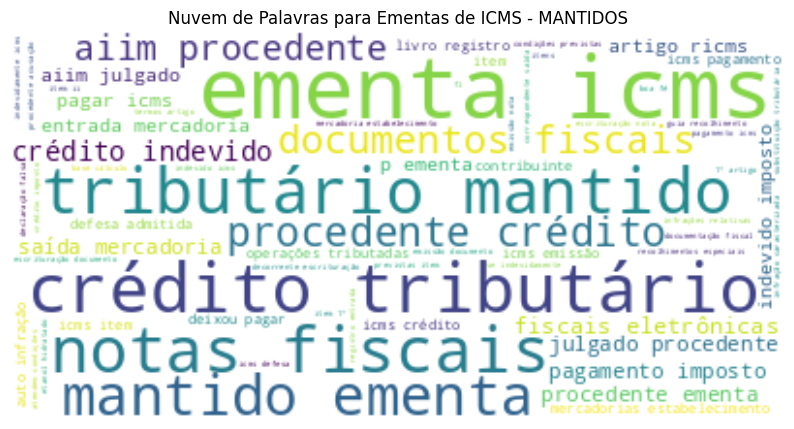

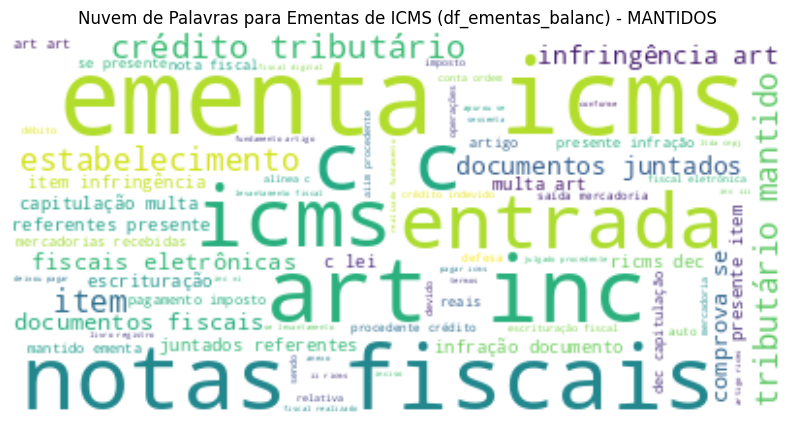

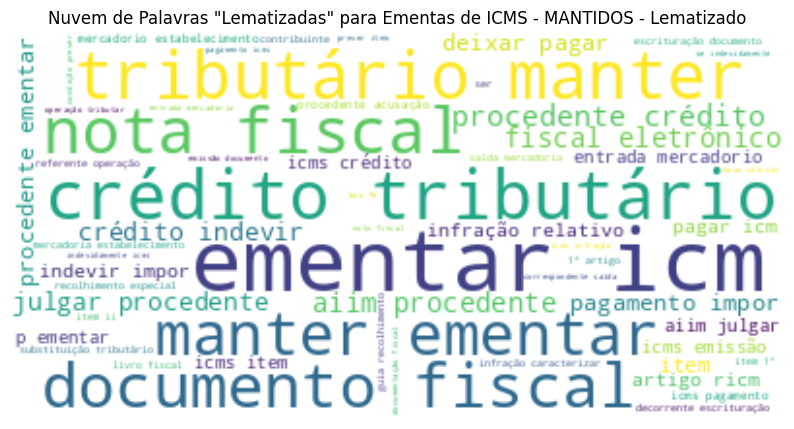

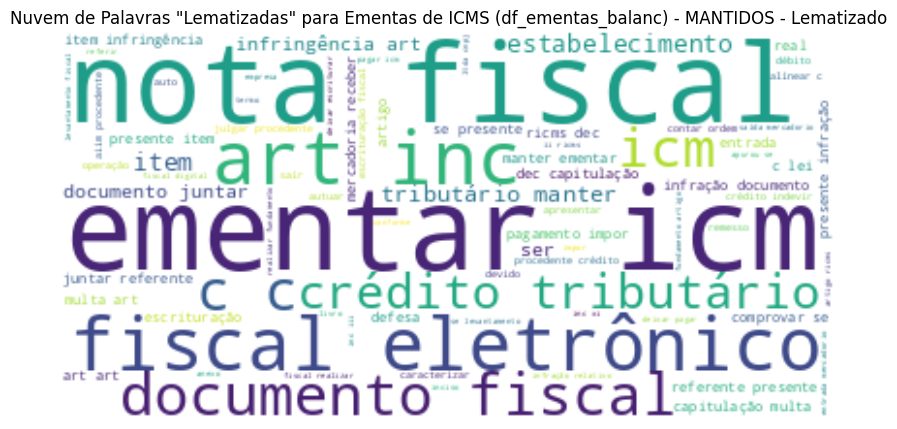

In [ ]:
gera_wordcloud(df_ementas[(df_ementas['target2'] == 'ICMS') & (df_ementas['target1'] == 'MANTIDO')],
               'Nuvem de Palavras para Ementas de ICMS - MANTIDOS', lematizado=False)
gera_wordcloud(df_ementas_balanc[(df_ementas_balanc['target2'] == 'ICMS') & (df_ementas_balanc['target1'] == 'MANTIDO')],
               'Nuvem de Palavras para Ementas de ICMS (df_ementas_balanc) - MANTIDOS', lematizado=False)
gera_wordcloud(df_ementas[(df_ementas['target2'] == 'ICMS') & (df_ementas['target1'] == 'MANTIDO')],
               'Nuvem de Palavras "Lematizadas" para Ementas de ICMS - MANTIDOS', lematizado=True)
gera_wordcloud(df_ementas_balanc[(df_ementas_balanc['target2'] == 'ICMS') & (df_ementas_balanc['target1'] == 'MANTIDO')],
               'Nuvem de Palavras "Lematizadas" para Ementas de ICMS (df_ementas_balanc) - MANTIDOS', lematizado=True)

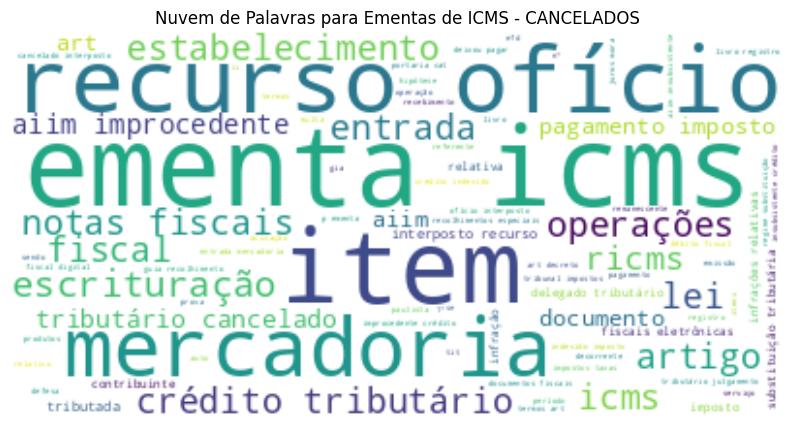

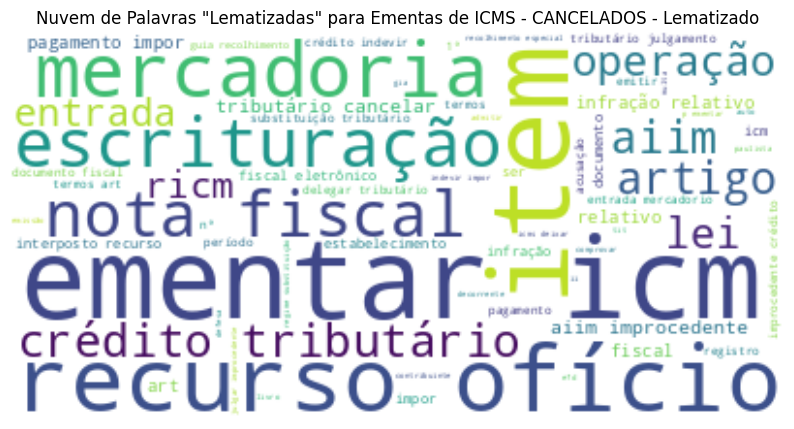

In [ ]:
gera_wordcloud(df_ementas[(df_ementas['target2'] == 'ICMS') & (df_ementas['target1'] == 'CANCELADO')],
               'Nuvem de Palavras para Ementas de ICMS - CANCELADOS', lematizado=False)
gera_wordcloud(df_ementas[(df_ementas['target2'] == 'ICMS') & (df_ementas['target1'] == 'CANCELADO')],
               'Nuvem de Palavras "Lematizadas" para Ementas de ICMS - CANCELADOS', lematizado=True)

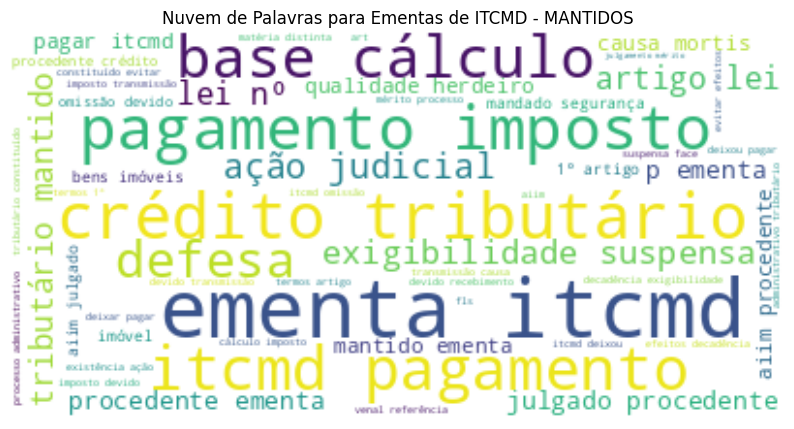

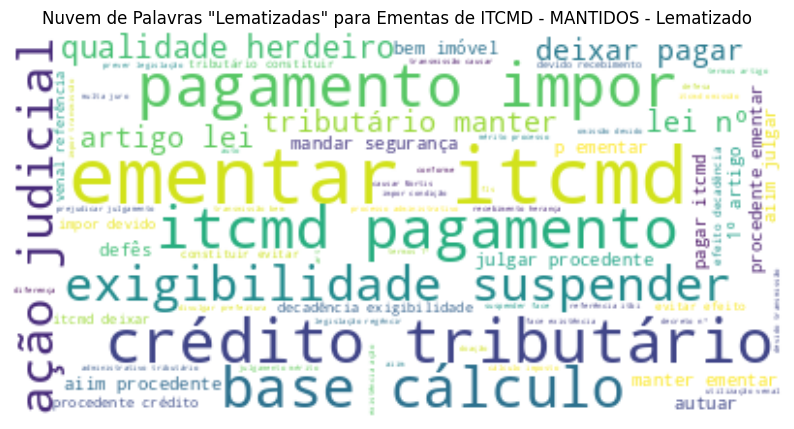

In [ ]:
gera_wordcloud(df_ementas[(df_ementas['target2'] == 'ITCMD') & (df_ementas['target1'] == 'MANTIDO')],
               'Nuvem de Palavras para Ementas de ITCMD - MANTIDOS', lematizado=False)
gera_wordcloud(df_ementas[(df_ementas['target2'] == 'ITCMD') & (df_ementas['target1'] == 'MANTIDO')],
               'Nuvem de Palavras "Lematizadas" para Ementas de ITCMD - MANTIDOS', lematizado=True)

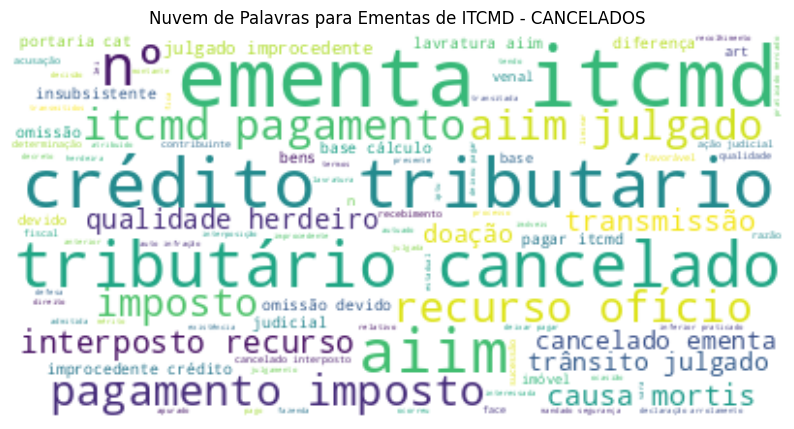

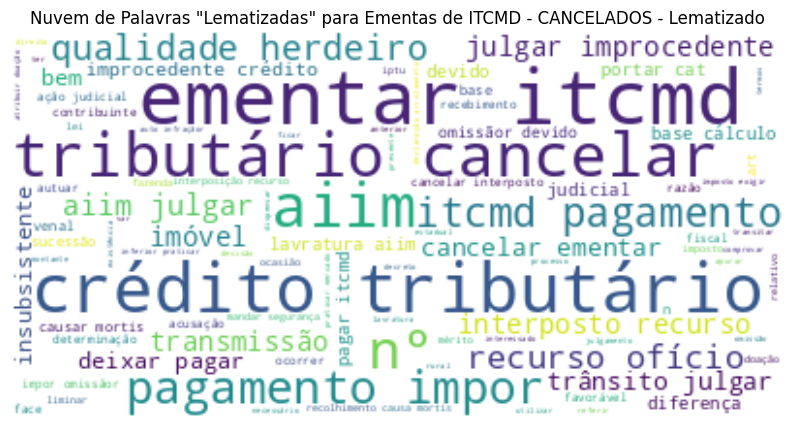

In [ ]:
gera_wordcloud(df_ementas[(df_ementas['target2'] == 'ITCMD') & (df_ementas['target1'] == 'CANCELADO')],
               'Nuvem de Palavras para Ementas de ITCMD - CANCELADOS', lematizado=False)
gera_wordcloud(df_ementas[(df_ementas['target2'] == 'ITCMD') & (df_ementas['target1'] == 'CANCELADO')],
               'Nuvem de Palavras "Lematizadas" para Ementas de ITCMD - CANCELADOS', lematizado=True)

A Análise de Componentes Principais (PCA) é uma técnica de redução de dimensionalidade que pode ser aplicada a dados numéricos. Para aplicar PCA aos tokens, você primeiro precisa converter os tokens em representações numéricas. Uma maneira comum de fazer isso é usando a técnica TF-IDF (Term Frequency-Inverse Document Frequency) ou embeddings de palavras, como Word2Vec.

Passos Gerais:
Converter Tokens em Vetores Numéricos: Converta os tokens em representações numéricas (TF-IDF, Word2Vec).
Aplicar PCA: Reduza a dimensionalidade dos vetores numéricos usando PCA.
Visualizar os Resultados: Plote os componentes principais para visualizar agrupamentos ou padrões nos dados.

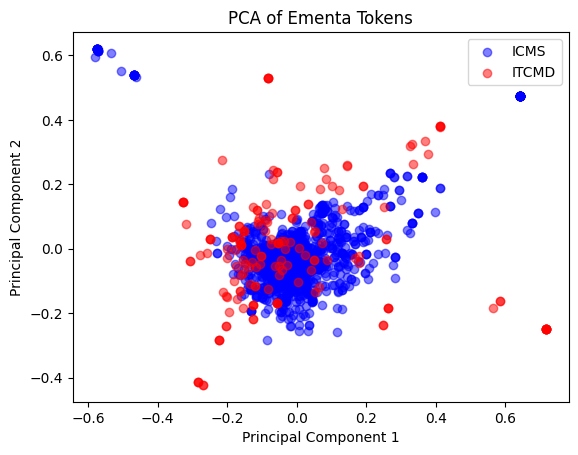

None

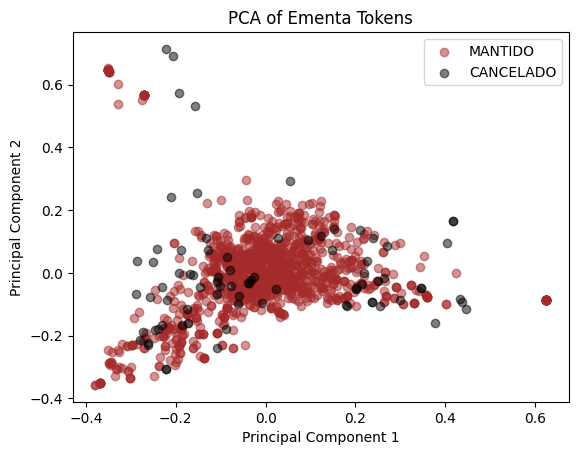

None

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def analise_pca(df, label, color):
    # Inicializar o vetorizador TF-IDF
    vectorizer = TfidfVectorizer()
    # Fit e transformar as strings de ementa para matriz TF-IDF
    X_tfidf = vectorizer.fit_transform(df['ementa_lematizada'])
    # Inicializar o objeto PCA e especificar o número de componentes principais
    pca = PCA(n_components=2)
    # Fit e transformar a matriz TF-IDF
    X_pca = pca.fit_transform(X_tfidf.toarray())
    # Plotar os componentes principais com a cor e a label específicas
    plt.scatter(X_pca[:, 0], X_pca[:, 1], color=color, alpha=0.5, label=label)


analise_pca(df_ementas[df_ementas['target2'] == 'ICMS'], 'ICMS', 'b')
analise_pca(df_ementas[df_ementas['target2'] == 'ITCMD'], 'ITCMD', 'r')
# Adicionar a legenda, título e mostrar o gráfico
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Ementa Tokens')
plt.legend(loc='upper right')
display(plt.show())

analise_pca(df_ementas[df_ementas['target1'] == 'MANTIDO'], 'MANTIDO', 'brown')
analise_pca(df_ementas[df_ementas['target1'] == 'CANCELADO'], 'CANCELADO', 'black')
# Adicionar a legenda, título e mostrar o gráfico
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Ementa Tokens')
plt.legend(loc='upper right')
display(plt.show())

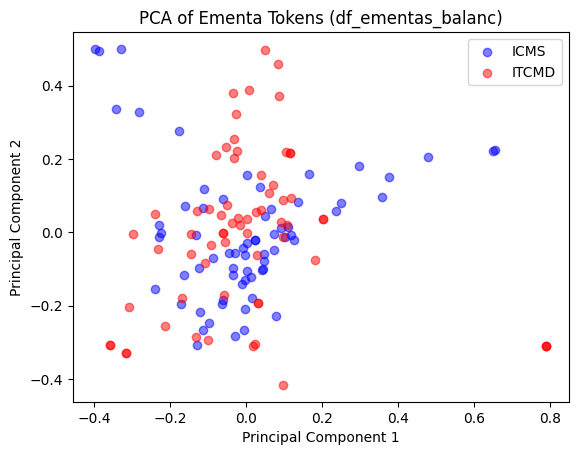

None

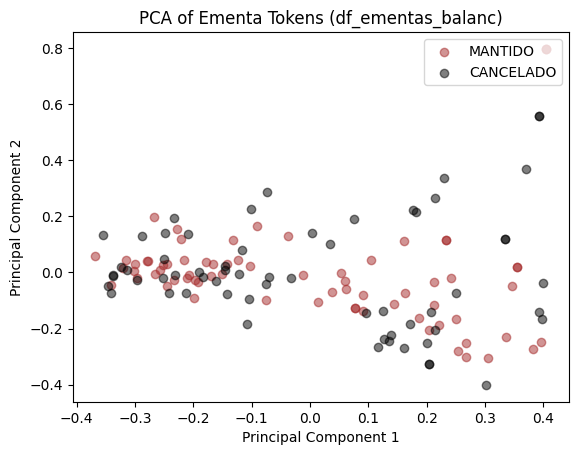

None

In [ ]:
analise_pca(df_ementas_balanc[df_ementas_balanc['target2'] == 'ICMS'], 'ICMS', 'b')
analise_pca(df_ementas_balanc[df_ementas_balanc['target2'] == 'ITCMD'], 'ITCMD', 'r')
# Adicionar a legenda, título e mostrar o gráfico
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Ementa Tokens (df_ementas_balanc)')
plt.legend(loc='upper right')
display(plt.show())

analise_pca(df_ementas_balanc[df_ementas_balanc['target1'] == 'MANTIDO'], 'MANTIDO', 'brown')
analise_pca(df_ementas_balanc[df_ementas_balanc['target1'] == 'CANCELADO'], 'CANCELADO', 'black')
# Adicionar a legenda, título e mostrar o gráfico
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Ementa Tokens (df_ementas_balanc)')
plt.legend(loc='upper right')
display(plt.show())

Este código irá plotar cada documento no espaço bidimensional definido pelos dois primeiros componentes principais.

Observação:
A análise de PCA pode revelar estruturas interessantes nos dados, mas interpretar essas estruturas pode ser um desafio, especialmente em dados de texto.
Se você tem classes ou categorias conhecidas nos seus dados, você pode colorir os pontos no gráfico de dispersão de acordo com essas classes para ver se o PCA revela algum padrão interessante ou separação entre as classes.
Para análise de texto, muitas vezes técnicas mais avançadas como t-SNE ou UMAP juntamente com embeddings de palavras oferecem visualizações mais informativas.

## Metodologias - Planejamentos - Objetivos <span class="label label-info"> 🚧 Em construção </span>

- Objetivos:
  - Discutir sobre o uso de Processamento de Linguagem Natural (PLN) para classificação das decisões
- Transformação e Tokenização:
  - Utilizar transformação e tokenização, transformando em números, para o modelo entender as relações entre eles. Ou seja, desenvolver uma forma em que o modelo possa interpretar.
- Modelos e Treinamento:
  - Discutir o treinamento de diferentes modelos, começando do mais simples ao mais complexo, para encontrar um equilíbrio entre precisão e complexidade. Exemplos: verificar a performance (acurácia) de modelos como KNN, Naive Bayes, etc
  - Estudar o modelo LSTM (Long Short-Term Memory), que tem sido bastante destacado por suas capacidades em processar linguagem natural, lidar com diferentes tamanhos de entrada, e ser combinado com outros modelos para tarefas como tradução de texto.
  - Estudar também outras bibliotecas de processamento de linguagem natural e modelos de aprendizado de máquina, como TF-IDF e Word2Vec.
- Avaliação e Otimização:
  - Discutir o processo de otimização dos modelos, a importância de evitar o overfitting, e como os modelos foram avaliados.
- Implementação e Deploy:
  - O deploy do modelo e a importância de salvar tanto o modelo quanto o tokenizador devem ser discutidos, buscando também manter a consistência no tratamento dos dados.
- Finalização:
  - Detacar a relevância do NLP na atualidade , encontrar uma linha entre otimização e resultado.

## 💡 Cursos e Links<a href="#top"><span style="float: right;">🔝</span></a><a id="links"></a>

#### Links para Guardar:

  [Top 25 Bibliotecas Python Para Data Science](https://blog.dsacademy.com.br/top-25-bibliotecas-python-para-data_science/)

  [Full Emoji List](https://unicode.org/emoji/charts/full-emoji-list.html)

  [Private GPT](https://www.youtube.com/watch?v=jxSPx1bfl2M)

  [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/README.md)
  
  [Dicas Formatação Jupyter Notebook e Markdown](https://brains.dev/2022/jupyter-notebooks-dicas-de-formatacao/)
  
  [Pandas Comparison with spreadsheets](https://pandas.pydata.org/docs/getting_started/comparison/comparison_with_spreadsheets.html#compare-with-spreadsheets)

  [Python Scripts to Automate Routine - Tem wikipedia, text to speech, pytube, PyPDF2, Python Imaging Library, gensim (para resumir textos), pywhatkit](https://www.youtube.com/watch?v=700s0pzjPhM)
  
  [Automate Excel Reporting Using Python (Real-Life-Example) | Pandas, Plotly, Xlwings Tutorial](https://www.youtube.com/watch?v=JoonRjMsSdY)

### Best Machine Learning &amp; Deep Learning Courses [2019]


[1. Machine Learning Certification by Stanford University (Coursera)](https://www.coursera.org/learn/machine-learning?ranMID=40328&amp;ranEAID=vedj0cWlu2Y&amp;ranSiteID=vedj0cWlu2Y-ajzPQo.U8IJDvdN2zJ4zsg&amp;siteID=vedj0cWlu2Y-ajzPQo.U8IJDvdN2zJ4zsg&amp;utm_content=10&amp;utm_medium=partners&amp;utm_source=linkshare&amp;utm_campaign=vedj0cWlu2Y)

[2. Deep Learning Certification by deeplearning.ai (Coursera)](https://www.coursera.org/specializations/deep-learning?edocomorp=mar19affiliate20off&amp;ranMID=40328&amp;ranEAID=vedj0cWlu2Y&amp;ranSiteID=vedj0cWlu2Y-ETlb9CJE2XM9JpTjEFCAhQ&amp;siteID=vedj0cWlu2Y-ETlb9CJE2XM9JpTjEFCAhQ&amp;utm_content=10&amp;utm_medium=partners&amp;utm_source=linkshare&amp;utm_campaign=vedj0cWlu2Y)

[3. Intro to Machine Learning Nanodegree Program (Udacity)](https://www.udacity.com/course/intro-to-machine-learning-nanodegree--nd229?cjevent=3f802ef9d42d11e983bf02e70a240613)

[4. Machine Learning A-Z™: Hands-On Python &amp; R In Data Science (Udemy)](https://www.udemy.com/machinelearning/?ranMID=39197&amp;ranEAID=vedj0cWlu2Y&amp;ranSiteID=vedj0cWlu2Y-Ocm.SbF0Nfu1joTCmj2lcw&amp;LSNPUBID=vedj0cWlu2Y)

[5. Machine Learning Data Science Course from Harvard University (edX)](https://www.edx.org/professional-certificate/harvardx-data-science?source=aw&amp;awc=6798_1568162694_f3d200d33df1e9f4c007eab412be2dc9&amp;utm_source=aw&amp;utm_medium=affiliate_partner&amp;utm_content=text-link&amp;utm_term=427859_Digital+Defynd)

[6. Deep Learning Course by IBM (edX)](https://www.edx.org/professional-certificate/ibm-deep-learning?source=aw&amp;awc=6798_1568162738_1040cabaa57d2f05641cb016f73b28e1&amp;utm_source=aw&amp;utm_medium=affiliate_partner&amp;utm_content=text-link&amp;utm_term=427859_Digital+Defynd)

[7. Mathematics for Machine Learning by Imperial College London (Coursera)](https://www.coursera.org/specializations/mathematics-machine-learning?ranMID=40328&amp;ranEAID=vedj0cWlu2Y&amp;ranSiteID=vedj0cWlu2Y-xLidZLlpjC8Gv_s2W4ZnVw&amp;siteID=vedj0cWlu2Y-xLidZLlpjC8Gv_s2W4ZnVw&amp;utm_content=10&amp;utm_medium=partners&amp;utm_source=linkshare&amp;utm_campaign=vedj0cWlu2Y)

[8. Machine Learning – Artificial Intelligence by Columbia University (edX)](https://www.edx.org/micromasters/columbiax-artificial-intelligence?source=aw&amp;awc=6798_1568162785_8665fc7be3791239252b43c78fc25d47&amp;utm_source=aw&amp;utm_medium=affiliate_partner&amp;utm_content=text-link&amp;utm_term=427859_Digital+Defynd)

[9. Free College Machine Learning Courses (edX)](https://www.edx.org/learn/machine-learning?source=aw&amp;awc=6798_1568162807_f9cb6b1e897a5e949c8f61b160df08fb&amp;utm_source=aw&amp;utm_medium=affiliate_partner&amp;utm_content=text-link&amp;utm_term=427859_Digital+Defynd)

[10. Machine Learning &amp; AI Courses (fast.ai)](https://www.fast.ai/)

[11. Advanced Machine Learning Course by HSE (Coursera)](https://www.coursera.org/specializations/aml?ranMID=40328&amp;ranEAID=vedj0cWlu2Y&amp;ranSiteID=vedj0cWlu2Y-e8Umkx_VMoYhoLYF2JIiLA&amp;siteID=vedj0cWlu2Y-e8Umkx_VMoYhoLYF2JIiLA&amp;utm_content=10&amp;utm_medium=partners&amp;utm_source=linkshare&amp;utm_campaign=vedj0cWlu2Y)

[12. Python for Data Science and Machine Learning Bootcamp (Udemy)](https://www.udemy.com/python-for-data-science-and-machine-learning-bootcamp/?ranMID=39197&amp;ranEAID=vedj0cWlu2Y&amp;ranSiteID=vedj0cWlu2Y-2yZi8gUVywIuAglcc34W9Q&amp;LSNPUBID=vedj0cWlu2Y)

[13. Deep Learning A-Z™: Hands-On Artificial Neural Networks (Udemy)](https://www.udemy.com/deeplearning/?ranMID=39197&amp;ranEAID=vedj0cWlu2Y&amp;ranSiteID=vedj0cWlu2Y-XBUM5R9N4AO.GHduAzNNpg&amp;LSNPUBID=vedj0cWlu2Y)

[14. Python for Everybody by University of Michigan (Coursera)](https://www.coursera.org/specializations/python?ranMID=40328&amp;ranEAID=vedj0cWlu2Y&amp;ranSiteID=vedj0cWlu2Y-Lc2RCZhix6fikqVzdQwKiw&amp;siteID=vedj0cWlu2Y-Lc2RCZhix6fikqVzdQwKiw&amp;utm_content=10&amp;utm_medium=partners&amp;utm_source=linkshare&amp;utm_campaign=vedj0cWlu2Y)

[15. Deep Learning in Python (DataCamp)](https://www.datacamp.com/courses/deep-learning-in-python?tap_a=5644-dce66f&amp;tap_s=463826-784532)

[16. Machine Learning Certification by University of Washington (Coursera)](https://www.coursera.org/specializations/machine-learning?ranMID=40328&amp;ranEAID=vedj0cWlu2Y&amp;ranSiteID=vedj0cWlu2Y-Cn0Cca6uS1hGwdb17rhacQ&amp;siteID=vedj0cWlu2Y-Cn0Cca6uS1hGwdb17rhacQ&amp;utm_content=10&amp;utm_medium=partners&amp;utm_source=linkshare&amp;utm_campaign=vedj0cWlu2Y)

In [ ]:
!pip check

No broken requirements found.


In [ ]:
%pip list